In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
batch_size = 32
num_stocks = 31
seq_len = 10
num_features = 10
num_market_features = num_features

beta = 10.01
units = 64
ft_dim = 32
n_heads = 12

In [ ]:
import os
from bluesunb.preprocessing.kospi_preprocessing import prepare_data
path = os.path.abspath('../data/preprocessed_kospi31_daily_stock_chart.csv')
option = {
    'window_size':seq_len,
    'test_pct':0.2,
    'valid_pct':0.2
}
market_data, stock_data, df= prepare_data(path, **option)
(X_train_m, y_train_m), (X_valid_m, y_valid_m), (X_test_m, y_test_m) = market_data
(X_train_s, y_train_s), (X_valid_s, y_valid_s), (X_test_s, y_test_s) = stock_data

In [3]:
from tensorflow.python.keras.layers import Layer, Dense, LSTM, MultiHeadAttention, LayerNormalization, Dropout, Input
from tensorflow.python.keras.models import Model

class FeatureTransformation(Layer):
    """
    Input: (None, stock, time, feature), (None, 1, time, feature)
    Output: (None, stock, time, ft_dim), (None, 1, time, ft_dim)
    """
    def __init__(self, ft_dim, **kwargs):
        super(FeatureTransformation, self).__init__()
        self.ft_dim = ft_dim

    def build(self, input_shape):
        shape = input_shape[0][1:]
        self.ft_linear = Dense(self.ft_dim,
                               input_shape=shape,
                               kernel_initializer='glorot_uniform',
                               bias_initializer='glorot_uniform',
                               activation='tanh')

    def call(self, inputs, *args, **kwargs):
        stock, market = inputs[0], inputs[1]
        stock = self.ft_linear(stock)
        market = self.ft_linear(market)
        return stock, market

    def get_config(self):
        config = super(FeatureTransformation, self).get_config().copy()
        config.update({'ft_dim':self.ft_dim})
        return config

class AttentionLSTM(Layer):
    """
    Input: (None, time, ft_dim)
    Output: (None, time, units)
    """
    def __init__(self, units, **kwargs):
        super(AttentionLSTM, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.lstm = LSTM(self.units, return_sequences=True, return_state=False)

    def call(self, inputs, *args, **kwargs):
        feature = self.lstm(inputs)
        attn_score = tf.matmul(feature, feature[:, -1:, :], transpose_b=True)
        feature = attn_score * feature
        return feature

    def get_config(self):
        config = super(AttentionLSTM, self).get_config().copy()
        config.update({'units':self.units})
        return config

class ContextNormalize(Layer):
    """
    Input: (None, time, units)
    Output: (None, time, units)
    """
    def __init__(self, **kwargs):
        super(ContextNormalize, self).__init__()

    def build(self, input_shape):
        shape = input_shape[1:]
        self.norm_weight = self.add_weight(name='norm_weight',
                                           shape=shape,
                                           initializer='uniform',
                                           trainable=True)

        self.norm_bias = self.add_weight(name='norm_bias',
                                         shape=shape,
                                         initializer='uniform',
                                         trainable=True)

    def call(self, inputs, *args, **kwargs):
        context = (inputs - tf.math.reduce_mean(inputs))/tf.math.reduce_std(inputs)
        context = self.norm_weight*context + self.norm_bias
        return context

    def get_config(self):
        config = super(ContextNormalize, self).get_config().copy()
        return config

class MultiAttentionLSTM(Layer):
    """
    Input: (None, num_stocks, time, ft_dim)
    Output: (None, time, units) * num_stocks
    """
    def __init__(self, units, num_stocks):
        super(MultiAttentionLSTM, self).__init__()
        self.units = units
        self.num_stocks = num_stocks

    def build(self, input_shape):
        self.attn_lstm = [AttentionLSTM(self.units) for _ in range(self.num_stocks)]
        self.context_norm = [ContextNormalize() for _ in range(self.num_stocks)]

    def call(self, inputs, *args, **kwargs):
        attn_weights = [self.attn_lstm[i](inputs[:, i, :, :]) for i in range(self.num_stocks)]
        attn_weights = [self.context_norm[i](attn_weights[i]) for i in range(self.num_stocks)]
        attn_weights = [tf.expand_dims(x, axis=1) for x in attn_weights]
        attn_weights = tf.concat(attn_weights, axis=1)
        return attn_weights

    def get_config(self):
        config = super(MultiAttentionLSTM, self).get_config().copy()
        config.update({'units': self.units,
                       'num_stocks':self.num_stocks})
        return config


class MultiLevelAggregator(Layer):
    """
    Input: (None, num_stocks, time, units), (None, 1, time, units)
    Output: (None, time, units)
    """
    def __init__(self, beta, **kwargs):
        super(MultiLevelAggregator, self).__init__()
        self.beta = beta

    def call(self, inputs, *args, **kwargs):
        context_stock, context_market = inputs[0], inputs[1]
        context = context_stock + self.beta*context_market
        context = tf.math.reduce_sum(context, axis=2)
        return context

    def get_config(self):
        config = super(MultiLevelAggregator, self).get_config().copy()
        config.update({'beta':self.beta})
        return config

class DataStack(Layer):
    """
    Input: (None, time, units) * num_stocks
    Output: (None, num_stocks, units)
    """
    def __init__(self, **kwargs):
        super(DataStack, self).__init__()

    def call(self, inputs, *args, **kwargs):
        inputs = [tf.expand_dims(x, axis=1) for x in inputs]
        inputs = tf.concat(inputs, axis=1)
        context = tf.math.reduce_sum(inputs, axis=2)
        return context

class NonlinearPrediction(Layer):
    """
    Input: (None, num_stocks, units)
    Output: (None, num_stocks, 1)
    """
    def __init__(self, **kwargs):
        super(NonlinearPrediction, self).__init__()

    def build(self, input_shape):
        hidden_size = input_shape[0][-1]
        self.mlp_linear1 = Dense(4*hidden_size,
                                 input_shape=input_shape,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform',
                                 activation='relu')

        self.mlp_linear2 = Dense(hidden_size,
                                 kernel_initializer='glorot_uniform',
                                 bias_initializer='glorot_uniform',
                                 activation='relu')

        self.mlp_dropout = Dropout(0.15)
        self.mlp_norm = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.pred_linear = Dense(1, activation='sigmoid',
                                 kernel_regularizer='l2', bias_regularizer='l2')

    def call(self, inputs, *args, **kwargs):
        context, attn_weight = inputs[0], inputs[1]
        residual_context = context + attn_weight

        mlp_weight = self.mlp_linear1(residual_context)
        mlp_weight = self.mlp_linear2(mlp_weight)

        residual_context = tf.nn.tanh(residual_context + mlp_weight)
        residual_context = self.mlp_dropout(residual_context)
        residual_context = self.mlp_norm(residual_context)

        output = self.pred_linear(residual_context)
        return output

In [4]:
from keras import backend as K
def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def create_model(n=num_stocks):
    num_stocks = n
    feature_transformation = FeatureTransformation(ft_dim)
    multi_attn_lstm1 = MultiAttentionLSTM(units, num_stocks)
    multi_attn_lstm2 = MultiAttentionLSTM(units, 1)
    multi_lvl_aggregator = MultiLevelAggregator(beta)
    attention = MultiHeadAttention(num_heads=n_heads, key_dim=128, value_dim=128,
                                   dropout=0.15)
    attn_norm = LayerNormalization(epsilon=1e-6)
    nonlinear_pred = NonlinearPrediction()

    stock_inputs = Input(shape=(num_stocks, seq_len, num_features))
    market_inputs = Input(shape=(1, seq_len, num_market_features))

    feature_stock, feature_market = feature_transformation([stock_inputs, market_inputs])
    context_stock = multi_attn_lstm1(feature_stock)
    context_market = multi_attn_lstm2(feature_market)

    context = multi_lvl_aggregator([context_stock, context_market])

    attn_weight = attention(context, context)
    attn_weight = attn_norm(attn_weight)
    output = nonlinear_pred([context, attn_weight])

    model = Model(inputs=[stock_inputs, market_inputs], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', mcc])

    return model

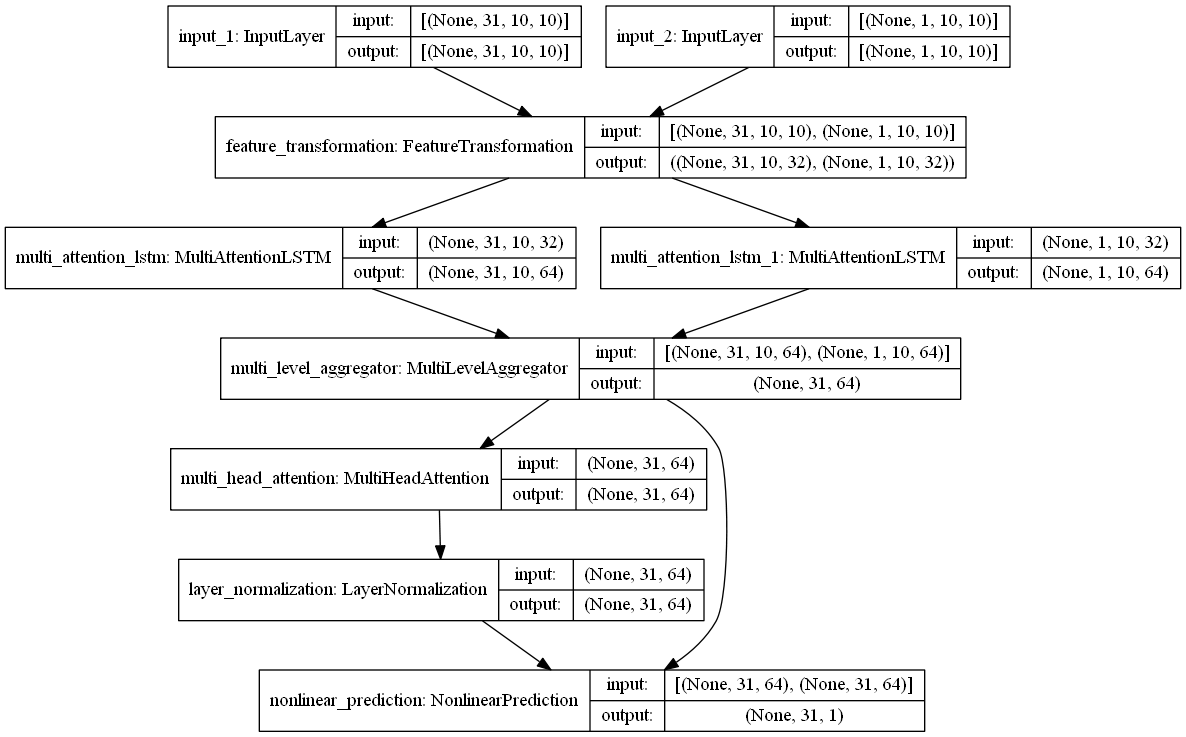

In [5]:
from tensorflow.python.keras.utils.vis_utils import plot_model
model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)